In [1]:
using DifferentialEquations, Parameters, ParameterizedFunctions, LinearAlgebra
using BenchmarkTools, Test, CSV, DataFrames, FastGaussQuadrature, StaticArrays
using Plots, ColorSchemes
using Revise
using Base.Threads

In [2]:
include("AtomInterferometrySims.jl")
using .AtomInterferometrySims

## phase maps

In [3]:
using CSV,DataFrames

phasemap = CSV.read("MZphase.csv",DataFrame;header=0)
phasemap = Matrix(phasemap);
phasemap = Matrix(transpose(phasemap));

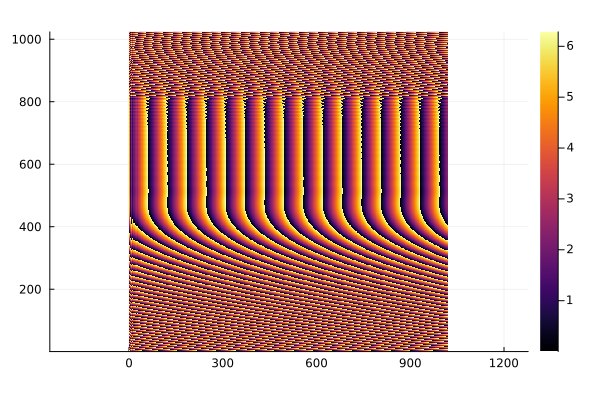

In [4]:
heatmap(phasemap,aspect_ratio = :equal)

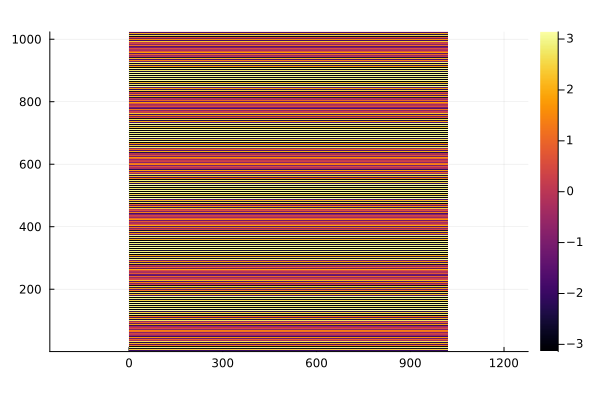

In [5]:
n = 1023
kx = 1e3
δ = π
phase_cos = [δ*cos(kx*i*1e-3) for i in 1:n,j in 1:n]
heatmap(phase_cos,aspect_ratio = :equal)

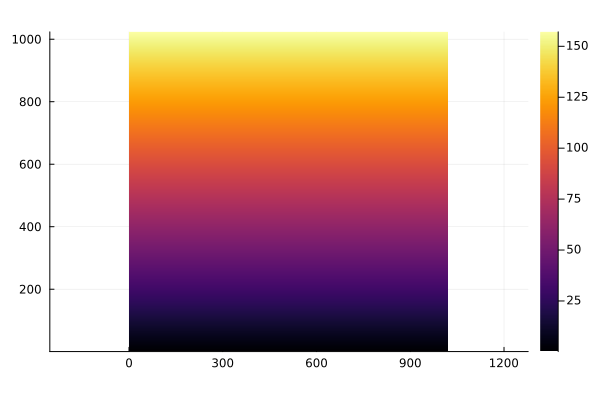

In [6]:
phase_shear = [50*δ*i/n for i in 1:n,j in 1:n]
heatmap(phase_shear,aspect_ratio=:equal)

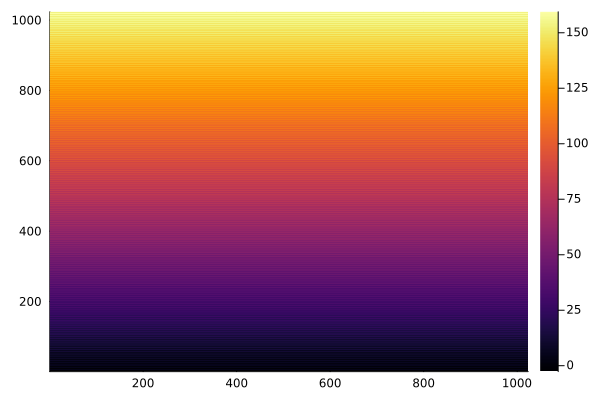

In [7]:
heatmap(phase_cos+phase_shear)

## Test example

In [8]:
num = 5000

cloud_r = 1e-3
cloud_T = 6e-3

phase_out = Vector{Float64}(undef,num)
pos_out = Matrix{Float64}(undef,num,3)

atom_init_pos = init_pos(cloud_r,num)
atom_init_vel = init_vel(cloud_T,num)

Threads.@threads for i in 1:num
    r = atom_init_pos[i,:]
    v = atom_init_vel[i,:]
    phase_out_temp, pos_out_temp = atom_phase_path_int_shear(r,v,0.,2e-3,1,phase_cos,phase_shear,1024*1e-3)
    phase_out[i] = phase_out_temp
    
    pos_out[i,:] = hcat(pos_out_temp)
    
end


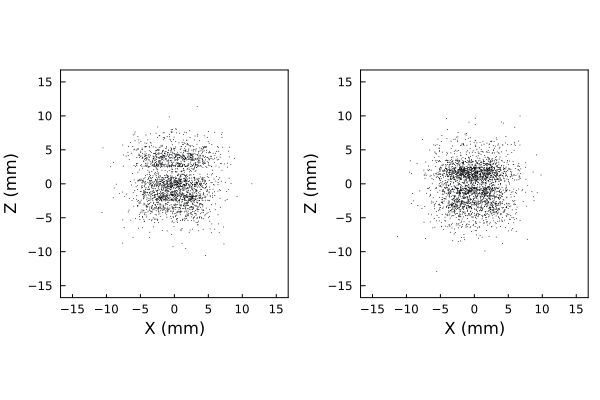

In [9]:
mask = [rand() > cos(x)^2 for x in phase_out]

final_pos = pos_out

zsig = -minimum(final_pos[:,2]) * 1e3 * 1.3 # rescale to mm, with 30% plot margin
prange = (-zsig,zsig)

p1 = scatter(
    final_pos[:,1][mask]*1e3,final_pos[:,2][mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false
)

p2 = scatter(
    final_pos[:,1][.!mask]*1e3,final_pos[:,2][.!mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false)

display(plot(p1,p2,layout = (1,2)))

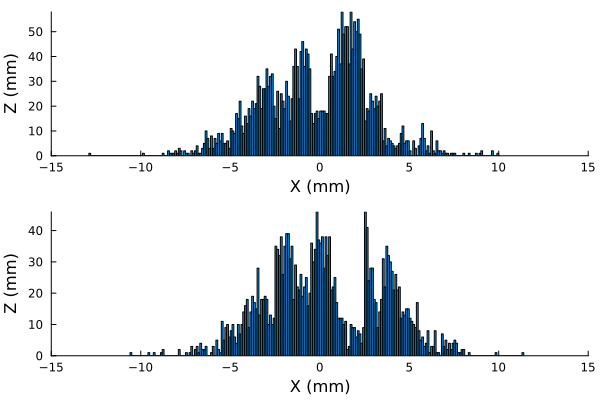

In [10]:
h1 = histogram(
    final_pos[:,2][.!mask]*1e3,
    #xlims = prange,ylims = prange,
    xlims = (-15,15),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

h2 = histogram(
    final_pos[:,2][mask]*1e3,
    #xlims = prange,ylims = prange,
    xlims = (-15,15),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

display(plot(h1,h2,layout = (2,1)))


## Full interferometer example

In [11]:
num = 5000

cloud_r = 1e-3
cloud_T = 6e-3

phase_out = Vector{Float64}(undef,num)
pos_out = Matrix{Float64}(undef,num,3)

atom_init_pos = init_pos(cloud_r,num)
atom_init_vel = init_vel(cloud_T,num)

Threads.@threads for i in 1:num
    r = atom_init_pos[i,:]
    v = atom_init_vel[i,:]
    phase_out_temp, pos_out_temp = atom_phase_path_int(r,v,0.,2e-3,1,phase_cos,1024*1e-3)
    phase_out[i] = phase_out_temp
    
    pos_out[i,:] = hcat(pos_out_temp)
    
end

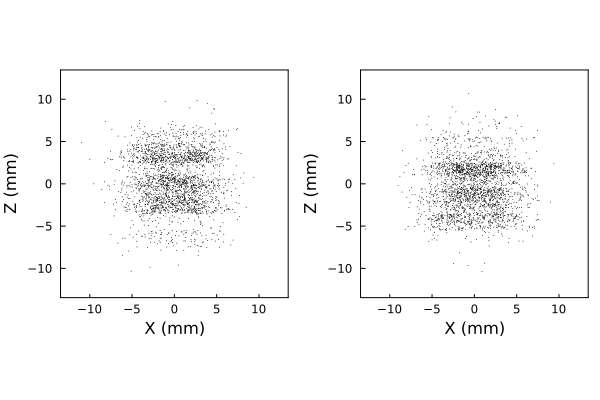

In [12]:
mask = [rand() > cos(x)^2 for x in phase_out]

final_pos = pos_out

zsig = -minimum(final_pos[:,2]) * 1e3 * 1.3 # rescale to mm, with 30% plot margin
prange = (-zsig,zsig)

p1 = scatter(
    final_pos[:,1][mask]*1e3,final_pos[:,2][mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false
)

p2 = scatter(
    final_pos[:,1][.!mask]*1e3,final_pos[:,2][.!mask]*1e3,
    xlims = prange,ylims = prange,
    xlabel = "X (mm)", ylabel = "Z (mm)",
    aspect_ratio = :equal,framestyle = :box,
    markershape=:circle, markersize=.1,
    legend = false,
    grid = false)


display(plot(p1,p2,layout = (1,2)))

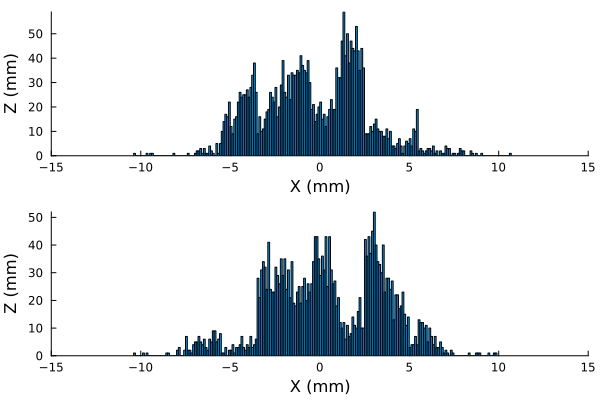

In [13]:
h1 = histogram(
    final_pos[:,2][.!mask]*1e3,
    #xlims = prange,ylims = prange,
    xlims = (-15,15),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

h2 = histogram(
    final_pos[:,2][mask]*1e3,
    #xlims = prange,ylims = prange,
    xlims = (-15,15),
    xlabel = "X (mm)", ylabel = "Z (mm)",
    #aspect_ratio = :equal,framestyle = :box,
    #markershape=:circle, markersize=.1,
    bin = 300,
    legend = false,
    grid = false)

display(plot(h1,h2,layout = (2,1)))